# Comparative Analysis of Chemical Composition in Red and White Wines: A Study on Volatile Acidity

In [ ]:
# Required libraries
library(tidyverse)
library(infer)
library(repr)
library(dplyr)
library(readr)
options(repr.plot.width=5, repr.plot.height=5)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:
# Reading in the data
url <- "https://archive.ics.uci.edu/static/public/186/wine+quality.zip"

# Define the local file name for the downloaded ZIP file
zip_file <- "data/wine_quality.zip"

# Download the ZIP file from the URL
download.file(url, destfile = zip_file)

# Unzip the downloaded file
unzip(zip_file, exdir = "data")

## Introduction

The goal of the project is to explore the average level of Volatile Acidity, Total Sulfur Dioxide and Chlorides in Red and White wine. The dataset, [Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality), is taken from [UCI Machine Learning Repository](https://archive.ics.uci.edu/datasets).

The dataset includes 13 attributes describing 

- ```Fixed Acidity```
- ```Volatile Acidity```
- ```Citric Acid```
- ```Residual Sugar```
- ```Chlorides```
- ```Free Sulfur Dioxide```
- ```Total Sulfur Dioxide```
- ```Density```
- ```pH```
- ```sulphates```
- ```alcohol```
- ```quality```

Research Question
<hr></hr>
How do the levels of <b>volatile acidity</b> differ between <b>red</b> and <b>white wines</b>, and are there statistically significant variations in these chemical components between the two wine types?

Our attribute of interest for this project is:

- ```Volatile Acidity```: Volatile acidity in the context of wine refers to the presence of volatile acids, primarily acetic acid.  It is a key factor in wine quality and can impact the wine's flavor and aroma.

To conduct research, we will be exploring the average levels (location parameter) of <b>volatile acidity</b> for each of the wines as well as standard deviation (scale parameter).

Volatile acidity plays a pivotal role in the winemaking process, and exhibits substantial variations across different wines. A study conducted by Babincev and Jović in 2021 delves into the chemical composition of white and red wines, revealing that white wine tends to have higher acidity levels compared to red wine. This finding underscores the importance and relevance of further investigation of volatile acidity.

## Methods and Results

We will be conducting a hypothesis test via bootstrapping, in order to examine the difference in mean volatile acidity between red and white wine (our test statistic). The null hypothesis is $H_{0}: \mu_{\text{Volatile Acidity of Red Wine}} - \mu_{\text{Volatile Acidity of White Wine}} = 0$ , and our alternative hypothesis is $H_{a}: \mu_{\text{Volatile Acidity of Red Wine}} - \mu_{\text{Volatile Acidity of White Wine}} \neq 0$. First, we plot the bootstrap distribution of the null hypothesis using the infer package. Then, we calculate the two-tailed p-value, given our observed statistic from our original sample (0.264). To determine if the difference in means between red and white wines is significant, we will compare the p-value to a 5% significance level.

### Wrangling the data

In [ ]:
# Read in the red and white wine data

wine_red_data <- read_delim("data/winequality-red.csv", delim = ";", show_col_types = FALSE) |>
                    mutate(type = "red")
wine_white_data <- read_delim("data/winequality-white.csv", delim = ";", show_col_types = FALSE)|>
                    mutate(type = "white")
# Check if we have missing values
sum(is.na(wine_white_data))
sum(is.na(wine_red_data)) 

In [ ]:
# Combining the red/white wine data and adding proper column names to the dataframe

wine_data <- rbind(wine_red_data, wine_white_data)
colnames(wine_data) <- c("fixed.acidity","volatile.acidity","citric.acid","residual.sugar",
                         "chlorides","free.sulfur.dioxide","total.sulfur.dioxide","density",
                         "pH","sulphates","alcohol","quality","type")
head(wine_data)

In [ ]:
wine_data_specific <- wine_data %>%
                        select(volatile.acidity, type)
head(wine_data_specific)

Firstly, we will take a sample from our dataset, ensuring to not take over 10% of the total observations as to avoid violation of independence.

In [ ]:
dim(wine_data_specific)

In [72]:
wine_data_specific <- wine_data %>%
                        select(volatile.acidity, type)
head(wine_data_specific)

volatile.acidity,type
<dbl>,<chr>
0.70,red
0.88,red
0.76,red
0.28,red
0.70,red
0.66,red


Firstly, we will take a sample from our dataset, ensuring to not take over 10% of the total observations as to avoid violation of independence.

# Preliminary Analysis #

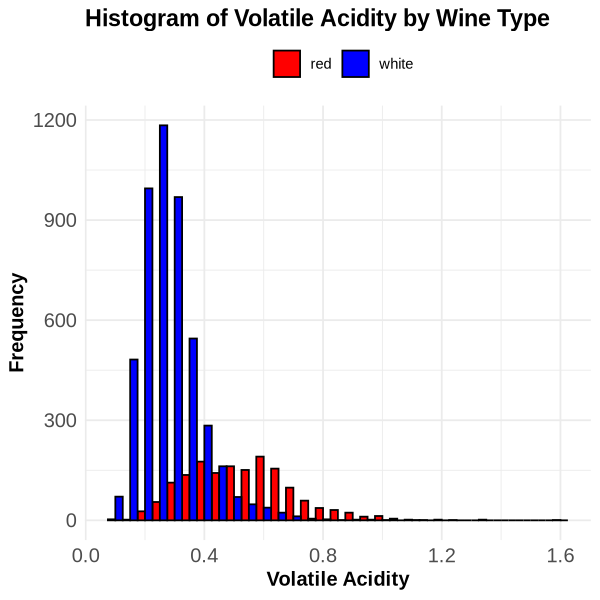

In [6]:
# Histogram of volatile acidity against the respective wine type

ggplot(wine_data_specific, aes(x = volatile.acidity, fill = type)) +
  geom_histogram(binwidth = 0.05, position = "dodge", color = "black") +
  labs(title = paste("Histogram of Volatile Acidity by Wine Type"), x = "Volatile Acidity", y = "Frequency") +
  scale_fill_manual(values = c("red" = "red", "white" = "blue")) +
  theme_minimal() +
  theme(legend.title = element_blank(),
        legend.position = "top",  # Change the legend position
        plot.title = element_text(size = 14, face = "bold"),  # Title style
        axis.text = element_text(size = 12),  # Axis label text size
        axis.title = element_text(size = 12, face = "bold"))

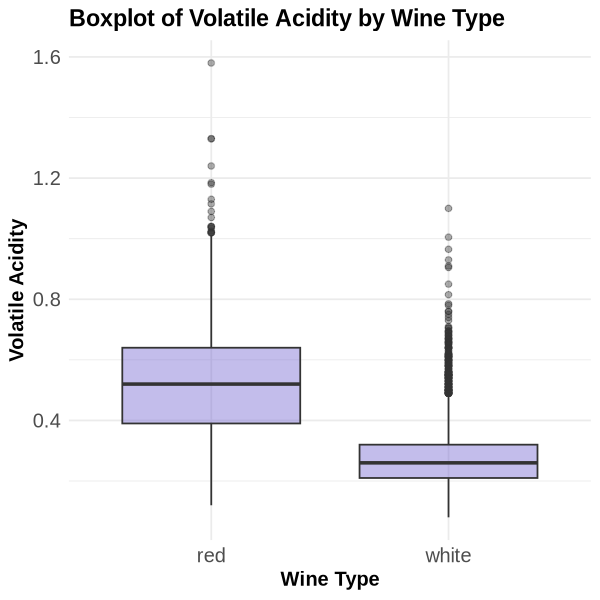

In [10]:
ggplot(wine_data_specific, aes(x = type, y = volatile.acidity)) +
      geom_boxplot(fill = "slateblue", alpha = 0.4) +
      labs(title = paste("Boxplot of Volatile Acidity by Wine Type", sep = " "), x = "Wine Type", y = "Volatile Acidity") +
      theme_minimal() +
      theme(legend.title = element_blank(),
            legend.position = "top",  # Change the legend position
            plot.title = element_text(size = 14, face = "bold"),  # Title style
            axis.text = element_text(size = 12),  # Axis label text size
            axis.title = element_text(size = 12, face = "bold"))

In [11]:
dim(wine_data_specific)

[1] 6497    2

In [12]:
set.seed(42) # Setting the seed for reproducible workflow

wine_sample <- wine_data_specific
head(wine_sample)

volatile.acidity,type
<dbl>,<chr>
0.15,white
0.34,white
0.11,white
0.30,white
0.52,red
0.58,red


Here we calculate the observed statistic, which is the difference in means.

In [73]:
obs_diff_in_means <- wine_sample %>%
    specify(volatile.acidity ~ type) %>%
    calculate(stat = "diff in means", order = c("red", "white"))
obs_diff_in_means

stat
<dbl>
0.2495794


We then create a null distribution, specifying our formula and generating 1000 bootstrapped replicates. From there we calculate the difference in means with red being our first variable and white being second.

In [74]:
null_dist <- wine_sample %>%
    specify(volatile.acidity ~ type) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 1000, type="permute") %>%
    calculate(stat = "diff in means", order = c("red", "white"))

### Calculating the CI

In [84]:
wine_ci <- wine_sample %>%
    specify(volatile.acidity ~ type) %>%
    generate(reps = 1000, type = "bootstrreap") %>%
    calculate(stat = "diff in means", order = c("red", "white")) %>%
    get_ci()
wine_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.2400692,0.2588344


After obtaining the null distribution, we can visualize it, and shade in the p value based on the observed statistic we calculated beforehand.

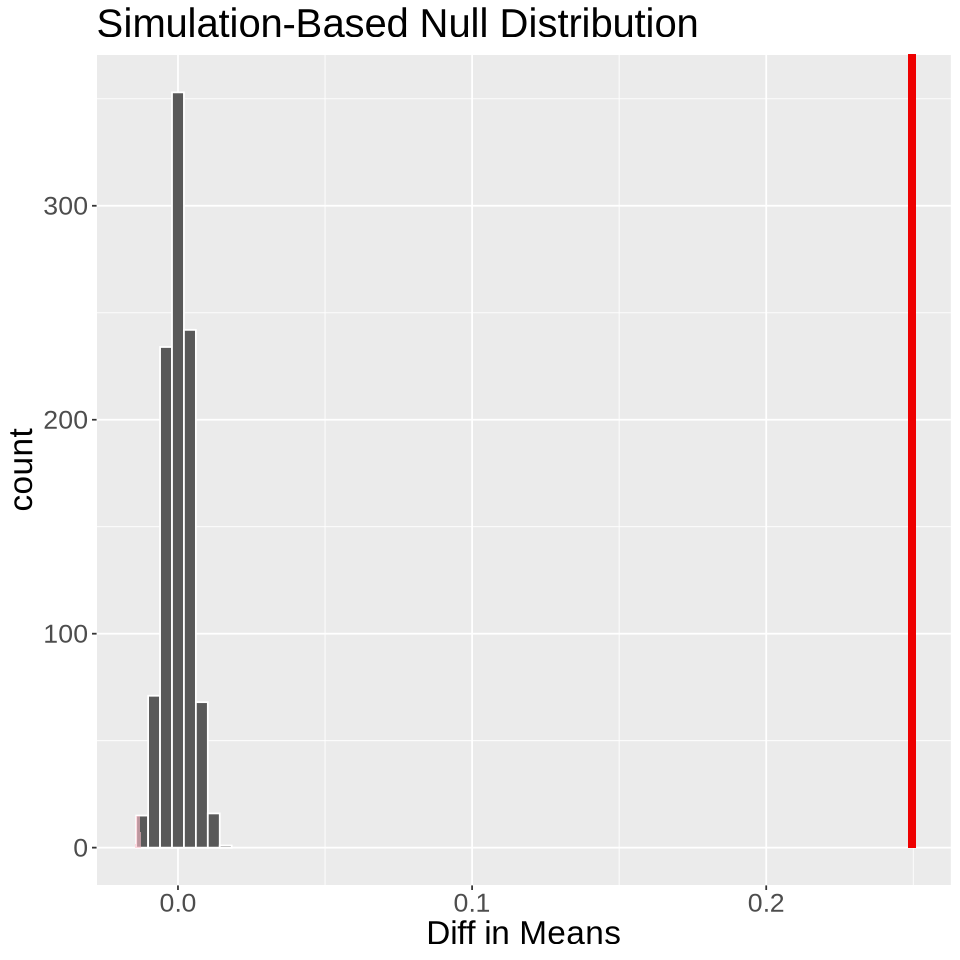

In [81]:
options(repr.plot.width=8, repr.plot.height=8)
visualize(null_dist, bins = 8) + 
    shade_p_value(obs_stat=obs_diff_in_means, direction = "two_sided") + theme(
    plot.title = element_text(size = 24), 
    axis.title.x = element_text(size = 20),  
    axis.title.y = element_text(size = 20),  
    axis.text.x = element_text(size = 16), 
    axis.text.y = element_text(size = 16)) +
    xlab("Diff in Means")

In [82]:
p_val <- null_dist %>%
    get_p_value(obs_stat = obs_diff_in_means, direction = "two-sided")
p_val

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


### Calculating CI with CLT

In [92]:
red <- wine_sample %>%
    filter(type == "red") %>%
    pull(volatile.acidity)

white <- wine_sample %>%
    filter(type == "white") %>%
    pull(volatile.acidity)

wine_diff_means_ci <- 
    tibble(
        lower_ci = mean(red) - mean(white) - qnorm(0.975) * sqrt(var(red)/length(red) + var(white)/length(white)),
        upper_ci = mean(red) - mean(white) + qnorm(0.975) * sqrt(var(red)/length(red) + var(white)/length(white))
    )
wine_diff_means_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.2403601,0.2587987


## Discussion

## References

- Babincev, L.M., Jović, S. Determination of the amount of volatile acids in oxidized wines and neutralization of these by using chemical reagents and biological materials. Biomass Conv. Bioref. 13, 4717–4725 (2023). https://doi.org/10.1007/s13399-021-01339-7
- Kelly M. Volatile Acidity in Wine PennState Extension https://extension.psu.edu/volatile-acidity-in-wine